# Thuật toán 2: K-Nearest Neighbors (KNN)

**Mục tiêu:** Xây dựng mô hình phi tuyến đầu tiên (`KNN`) để dự đoán và so sánh hiệu suất với mô hình baseline (`Logistic Regression`)

**Logic thuật toán:** KNN là một thuật toán học có giám sát *dựa trên thể hiện* (`instance-based`). Thuật toán này không tạo ra một hàm số cụ thể mà lưu trữ toàn bộ tập huấn luyện. Khi dự đoán, nó tìm $k$ điểm dữ liệu gần nhất trong tập huấn luyện và dự đoán dựa trên *phiếu bầu đa số* (`majority vote`) của các điểm đó.

**Các bước thực hiện:**

1. **Giai đoạn 1: Tải và Tiền xử lý Dữ liệu (Sử dụng lại từ phần trước):** KNN rất nhạy với scale của dữ liệu nên việc chuẩn hóa (Scaling) mà chúng ta đã thực hiện ở Thuật toán 1 là rất cần thiết.
2. **Giai đoạn 2: Xây dựng Mô hình (Cơ bản):** Huấn luyện mô hình KNN với giá trị $k$ cơ bản ($k$ = 5).
3. **Giai đoạn 3: Đánh giá Mô hình (Cơ bản):** Đánh giá hiệu suất cơ bản.
4. **Giai đoạn 4: Tinh chỉnh Hyperparameter (Phần chính):** Tìm giá trị $k$ tối ưu.
5. **Giai đoạn 5: Kết luận:** Đánh giá mô hình KNN hoàn chỉnh so với `Baseline`.

## Giai đoạn 1: Tải và Tiền xử lý Dữ liệu

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Tải dữ liệu
data = pd.read_csv('heart.csv')

# Xóa các hàng trùng lặp
print(f"Số hàng ban đầu: {len(data)}")
data = data.drop_duplicates()
print(f"Số hàng sau khi xóa trùng lặp: {len(data)}")

# Tách X(features) và y(target)
X = data.drop('HeartDisease', axis=1)
Y = data["HeartDisease"]

# 1. Biến Categorical: One-hot Encoding
categorical_cols = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Biến Numerical: Scaling:\
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"Tập huấn luyện: {X_train.shape}\nTập kiểm tra: {X_test.shape}")

Số hàng ban đầu: 918
Số hàng sau khi xóa trùng lặp: 918
Tập huấn luyện: (734, 15)
Tập kiểm tra: (184, 15)


## Giai đoạn 2: Xây dựng Mô hình cơ bản

In [20]:
# Khởi tạo mô hình với k=5
model = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='distance')

# Huấn luyện mô hình
model.fit(X_train, Y_train)

print ("Mô hình KNN đã được huấn luyện với k=5.")

Mô hình KNN đã được huấn luyện với k=5.


# Giai đoạn 3: Đánh giá Mô hình cơ bản

--- Kết quả đánh giá KNN (k=5) ---
Accuracy: 0.8370
Precision: 0.8667
Recall: 0.8505
F1-Score: 0.8585


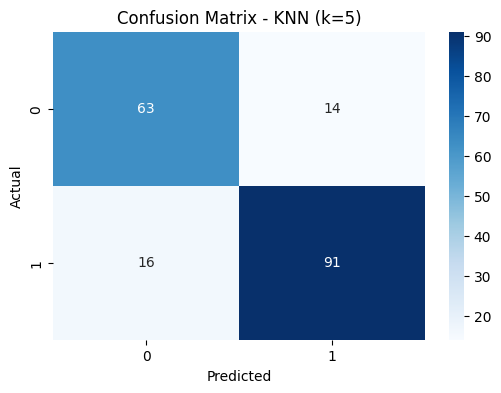

In [25]:
# Dự đoán trên tập test
Y_pred = model.predict(X_test)

# Tính các chỉ số đánh giá
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

print("--- Kết quả đánh giá KNN (k=5) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Ma trận nhầm lẫn
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN (k=5)')
plt.show()

## Giai đoạn 4: Tinh chỉnh Hyperparameter (Phần chính)

Hiệu suất của KNN phụ thuộc vào việc chọn $k$ và các tham số khác. Ta cần tìm một phương pháp để tìm ra các tham số tốt nhất.

1. **Tìm $k$ tối ưu (Elbow Method):** Thử chạy mô hình với nhiều giá trị $k$ (từ 1 đến 30) và vẽ biểu đồ lỗi (Error Rate). Chúng ta tìm điểm "Elbow" với Error Rate ngừng giảm đáng kể. Error Rate = 1 - Accuracy.
2. **Tinh chỉnh toàn diện (GridSearchCV):** Tự động tìm kiếm tổ hợp tốt nhất của `n_neighbors`, `weights` và `metric`.

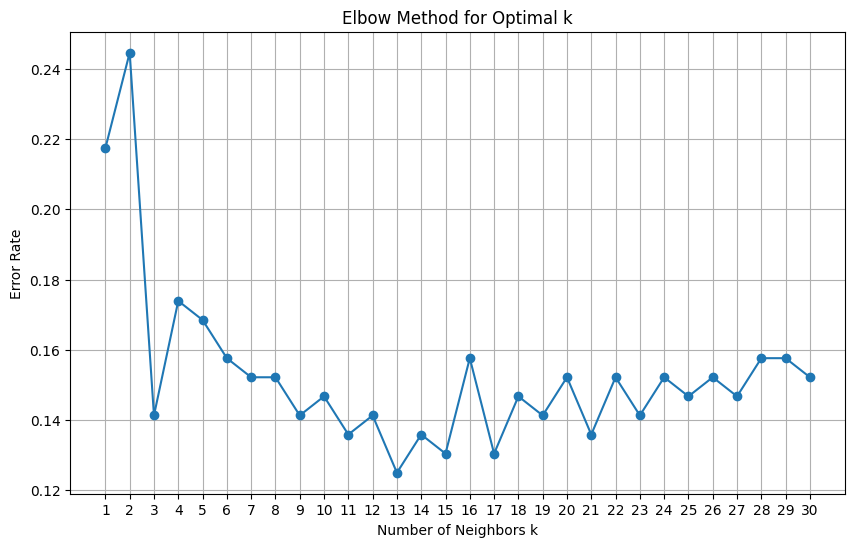

In [22]:
# 1. TÌm k tối ưu (Elbow Method)
error_rates = []
k_values = range(1, 31)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred_k = knn.predict(X_test)
    error = np.mean(1 - accuracy_score(Y_test, Y_pred_k))
    error_rates.append(error)

# Vẽ biểu đồ Error Rate theo k
plt.figure(figsize=(10,6))
plt.plot(k_values, error_rates, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Neighbors k')
plt.ylabel('Error Rate')
plt.xticks(k_values)
plt.grid()
plt.show()

**Nhận xét biểu đồ (Elbow Method):** Nhìn vào biểu đồ, chúng ta có thể thấy Error Rate thấp ở $k$ nhỏ và bắt đầu ổn định khi $k$ nằm trong khoảng 15-24. Điều này thể hiện rằng $k$ nằm trong khoảng này.

In [23]:
# 2. Tinh chỉnh toàn diện (GridSearchCV)
param_grid = {
    'n_neighbors': list(range(1, 31)),
    'weights': ['distance', 'uniform'],
    'metric': ['euclidean', 'manhattan', 'chebyshev']
}

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, Y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print (f"Best F1-Score from GridSearchCV: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
Best F1-Score from GridSearchCV: 0.8890


## Giai đoạn 5: Kết luận

--- Kết quả đánh giá KNN sau khi Tuning ---
Accuracy: 0.8804
Precision: 0.8972
Recall: 0.8972
F1-Score: 0.8972


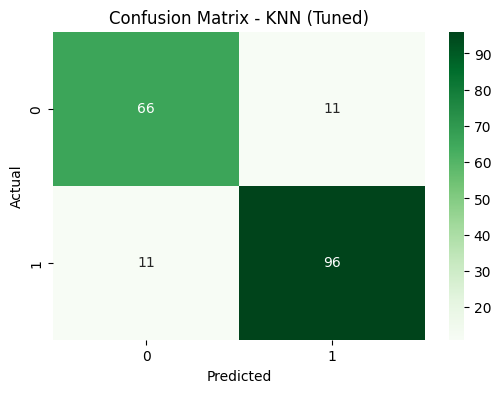

In [24]:
# Đánh giá mô hình KNN tốt nhất:

best_knn = grid_search.best_estimator_
Y_pred_best = best_knn.predict(X_test)

print("--- Kết quả đánh giá KNN sau khi Tuning ---")
print(f"Accuracy: {accuracy_score(Y_test, Y_pred_best):.4f}")
print(f"Precision: {precision_score(Y_test, Y_pred_best):.4f}")
print(f"Recall: {recall_score(Y_test, Y_pred_best):.4f}")
print(f"F1-Score: {f1_score(Y_test, Y_pred_best):.4f}")

# Ma trận nhầm lẫn sau khi tuning
cm_best = confusion_matrix(Y_test, Y_pred_best)
plt.figure(figsize=(6,4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN (Tuned)')
plt.show()